# Лабораторная 6

Задание: Развернуть нейросеть FaceNet и дообучить ее определять членов вашей команды по лицам.

Мы используем FaceNet как фиксированный экстрактор признаков лиц и обучаем отдельный классификатор (SVM) для распознавания членов команды по этим признакам.

In [1]:
from facenet_pytorch import InceptionResnetV1, MTCNN
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import os
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import pickle
import cv2
import matplotlib.pyplot as plt

Загрузка предобученной модели FaceNet для извлечения признаков лиц.

Инициализация MTCNN для детекции лиц на изображениях

In [2]:
model = InceptionResnetV1(pretrained='vggface2').eval()
mtcnn = MTCNN(image_size=160, margin=20)

Функция получения эмбеддинга лица из фото

In [3]:
def get_embedding(img_path):
    try:
        img = Image.open(img_path).convert('RGB')
        face_tensor = mtcnn(img)
        if face_tensor is None:
            print(f"Лицо не найдено: {img_path}")
            return None
        embedding = model(face_tensor.unsqueeze(0))
        return embedding.detach().numpy()[0]
    except Exception as e:
        print(f"Ошибка с {img_path}: {e}")
        return None

Папка faces содержит подпапки с фото(Elena, Kris)

In [4]:
data_dir = 'faces'  
X, y = [], []

In [5]:
for person in os.listdir(data_dir):
    person_path = os.path.join(data_dir, person)
    if not os.path.isdir(person_path):
        continue
    print(f"Обработка: {person}")
    for img_name in os.listdir(person_path):
        img_path = os.path.join(person_path, img_name)
        embedding = get_embedding(img_path)
        if embedding is not None:
            X.append(embedding)
            y.append(person)

Обработка: Elena
Обработка: Kris


Преобразуем списки в массивы

In [6]:
X = np.array(X)
y = np.array(y)

Кодируем метки в числовой формат

In [7]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

Обучение

In [8]:
classifier = SVC(kernel='linear', probability=True)
classifier.fit(X, y_encoded)

SVC(kernel='linear', probability=True)

### Проверка обучения

Функция для распознавания лиц на видео и вывода первого кадра с найденным лицом

In [9]:
def showvideo(video_path, confidence_threshold=0.5):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Не удалось открыть видео: {video_path}")
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Видео закончилось, лицо не найдено.")
            break

        img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        boxes, _ = mtcnn.detect(img)

        if boxes is None:
            continue

        for box in boxes:
            x1, y1, x2, y2 = map(int, box)
            face_img = frame[y1:y2, x1:x2]

            try:
                face = Image.fromarray(face_img).convert('RGB')
                face_tensor = mtcnn(face)
                if face_tensor is not None:
                    embedding = model(face_tensor.unsqueeze(0))
                    embedding_np = embedding.detach().numpy()
                    probs = classifier.predict_proba(embedding_np)[0]
                    pred_idx = np.argmax(probs)
                    name = encoder.inverse_transform([pred_idx])[0]
                    confidence = probs[pred_idx]

                    if confidence > confidence_threshold:
                        label = f"{name} ({confidence:.2f})"
                        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                        text_scale = 4.0
                        text_thickness = 4
                        (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, text_scale, text_thickness)
                        cv2.rectangle(frame,
                                      (x1, y1 - text_height - 10),
                                      (x1 + text_width + 10, y1),
                                      (0, 0, 0),
                                      -1)
                        cv2.putText(frame, label,
                                    (x1 + 5, y1 - 5),
                                    cv2.FONT_HERSHEY_SIMPLEX,
                                    text_scale,
                                    (255, 255, 255),
                                    text_thickness,
                                    lineType=cv2.LINE_AA)

                        # Показываем кадр и сразу выходим из функции
                        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        plt.figure(figsize=(10, 6))
                        plt.imshow(frame_rgb)
                        plt.axis('off')
                        plt.title(f"Распознано лицо: {name} (уверенность {confidence:.2f})")
                        plt.show()
                        cap.release()
                        return

            except Exception as e:
                print(f"Ошибка при обработке лица: {e}")

    cap.release()

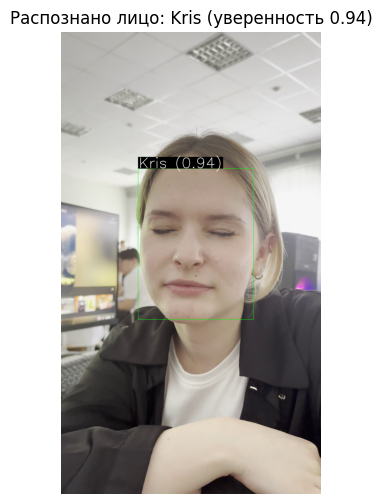

In [10]:
showvideo('videotest.mp4', confidence_threshold=0.5)

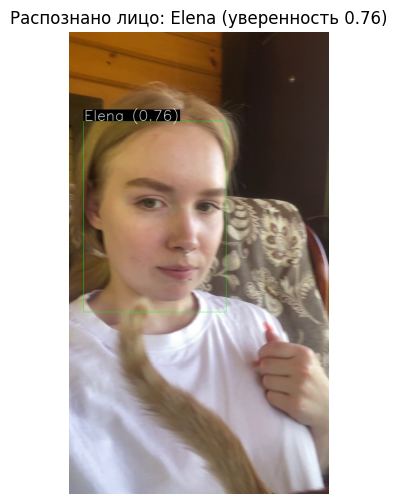

In [11]:
showvideo('videotest2.mp4', confidence_threshold=0.5)